# Siamese Text Similarity

- **https://github.com/sainimohit23/siamese-text-similarity**
  - https://github.com/MahmoudWahdan/Siamese-Sentence-Similarity
  - https://github.com/avinashsai/Siamese-Recurrent-Architectures-for-Sentence-Similarity
  - https://github.com/TharinduDR/Siamese-Recurrent-Architectures
- https://nlp.stanford.edu/projects/glove/
  - https://nlp.stanford.edu/data/glove.6B.zip
- `conda install tensorflow-gpu`
- monkeypatch: https://github.com/tensorflow/models/issues/9706#issuecomment-877788105
- https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
- https://keras.io/examples/nlp/bidirectional_lstm_imdb/

```bash
conda install tensorflow-gpu  # conda install cudatoolkits etc.
conda install jupyterlab
#conda install Keras  # ?
# monkeypatch tensorflow array_ops ...
pip install numpy tqdm matplotlib scikit-learn pandas
```

In [ ]:
import csv
import dataclasses
import json
import os
import gc
import pickle
import re
import string
import time
from dataclasses import dataclass
from enum import Enum
from typing import List, Optional, Union

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#from tqdm.keras import TqdmCallback


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

classes

In [3]:
# https://github.com/huggingface/transformers/blob/9f72e8f4e1e767c5f608dd135199e592255b8a69/src/transformers/data/processors/utils.py


@dataclass
class InputExample:
    """
    A single training/test example for simple sequence classification.
    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
    """

    guid: str
    text_a: str
    text_b: Optional[str] = None
    label: Optional[str] = None

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"
    

class Split(Enum):
    train = "train"
    dev = "dev"
    test = "test"
    pred = "pred"


class SameSentimentDataProcessor:
    """Base class for data converters for sequence classification data sets."""
    
    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.
        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence1"].numpy().decode("utf-8"),
            tensor_dict["sentence2"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )
    
    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train"
        )

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev"
        )

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.tsv")), "test"
        )

    def get_pred_examples(self, data_dir):
        """Get prediction examples (no label in dataset)."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "pred.tsv")), "pred"
        )
    
    def get_labels(self):
        """Gets the list of labels for this data set."""
        return ["0", "1"]
        
    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            # TODO: has headers?
            # if i == 0:
            #     continue
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[1]
            text_b = line[2]
            label = None if set_type == "pred" else line[-1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label)
            )
        return examples

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

---

In [4]:
EMBEDDING_DIM = 50  # 50, 100, 200, 300
MAX_SEQUENCE_LENGTH = 256
VALIDATION_SPLIT = 0.1  # ?
RATE_DROP_LSTM = 0.17
RATE_DROP_DENSE = 0.25
NUMBER_LSTM = 50  # 15
NUMBER_DENSE_UNITS = 50
ACTIVATION_FUNCTION = 'relu'

NUM_EPOCHS = 20  # 200
BATCH_SIZE = 512  # 1024  # 64

assert EMBEDDING_DIM in (50, 100, 200, 300)
fn_vectors = "../test/siamese-text-similarity/glove.6B.{}d.txt".format(EMBEDDING_DIM)
fn_data = "./data/sentiment/yelp-pair-b"
path = "data/siamese"

os.makedirs(path, exist_ok=True)

fn_cached_vocab = os.path.join(path, "cached_vocab_{}.p".format(EMBEDDING_DIM))
fn_cached_train = os.path.join(path, "cached_{}_{}.p".format(Split.train.value, MAX_SEQUENCE_LENGTH))
fn_cached_dev = os.path.join(path, "cached_{}_{}.p".format(Split.dev.value, MAX_SEQUENCE_LENGTH))
fn_cached_test = os.path.join(path, "cached_{}_{}.p".format(Split.test.value, MAX_SEQUENCE_LENGTH))
fn_best_model = os.path.join(path, "bestmodel_{}_{}_{}.txt".format(MAX_SEQUENCE_LENGTH, NUM_EPOCHS, BATCH_SIZE))

---

load data (prep text fn)

In [5]:
def load_tsv_data(data_dir, processor, mode=None):
    if mode == Split.dev:
        examples = processor.get_dev_examples(data_dir)
    elif mode == Split.test:
        examples = processor.get_test_examples(data_dir)
    elif mode == Split.pred:
        examples = processor.get_pred_examples(data_dir)
    else:
        examples = processor.get_train_examples(data_dir)

    guid, text_a, text_b, label = list(), list(), list(), list()
    for example in examples:
        guid.append(example.guid)
        text_a.append(example.text_a)
        text_b.append(example.text_b)
        label.append(example.label)
        
    guid = np.array(guid)
    text_a = np.array(text_a)
    text_b = np.array(text_b)
    label = np.array(label)

    return guid, text_a, text_b, label

In [6]:
def clean_text(lines):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    cleaned = list()
    for text in lines:
        text = text.lower()
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"that's", "that is", text)
        text = re.sub(r"what's", "that is", text)
        text = re.sub(r"where's", "where is", text)
        text = re.sub(r"how's", "how is", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"n'", "ng", text)
        text = re.sub(r"'bout", "about", text)
        text = re.sub(r"'til", "until", text)
        # remove punctuation
        text = re.sub(r"[$-()\"#/@;:<>{}`+=~|.!?,'*-]", "", text)
                         
        text = text.split()
        text = [re_print.sub('', w) for w in text]
        
        cleaned.append(' '.join(text))

    cleaned = np.array(cleaned)

    return cleaned

In [7]:
def read_glove_vectors(path):
    """
    read Glove Vector Embeddings
    """
    
    with open(path, encoding='utf8') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            cur_word = line[0]
            words.add(cur_word)
            word_to_vec_map[cur_word] = np.array(line[1:], dtype=np.float64)

    i = 1
    words_to_index = {}
    index_to_words = {}
    for w in sorted(words):
        words_to_index[w] = i
        index_to_words[i] = w
        i = i + 1

    return words_to_index, index_to_words, word_to_vec_map


def update_special_tokens(vocab_to_int, int_to_vocab, word_to_vec_map):
    """ Special Tokens """
    for code in ['<PAD>', '<EOS>', '<UNK>', '<GO>']:
        vocab_to_int[code] = len(vocab_to_int) + 1
        int_to_vocab[len(int_to_vocab)+1] = code
        word_to_vec_map[code] = np.random.random(50)
    
    return vocab_to_int, int_to_vocab, word_to_vec_map

preprocess

In [8]:
def preprocess(fn_data, vocab_to_int, int_to_vocab, word_to_vec_map, max_len=15, mode=None, filter_too_long=False):
    processor = SameSentimentDataProcessor()
    
    guid, sent1, sent2, labels = load_tsv_data(fn_data, processor, mode)

    # --------------------------------

    # clean text, remove contractions, tokenize
    sent1 = clean_text(sent1)
    sent2 = clean_text(sent2)

    guid = np.array(guid)
    sent1 = np.array(sent1)
    sent2 = np.array(sent2)
    labels = np.array(labels)

    # --------------------------------
    
    if filter_too_long:
        # remove everything to long
        def get_short_indices(length, sentences):
            """
            Filter out sequences with length "length"
            """
            idx = np.zeros((len(sentences)), dtype=bool)   
            for num, sent in enumerate(sentences):
                if len(sent.strip().split()) <= length:
                    idx[num] = 1
            return idx

        dx = get_short_indices(max_len, sent1)
        guid = guid[dx]
        sent1 = sent1[dx]
        sent2 = sent2[dx]
        labels = labels[dx]

        dx = get_short_indices(max_len, sent2)
        guid = guid[dx]
        sent1 = sent1[dx]
        sent2 = sent2[dx]
        labels = labels[dx]
        
    else:
        # just trim first, so leaks do not contain the pad character
        def _trim_too_long(length, sentences):
            for idx in range(len(sentences)):
                tokens = sentences[idx].strip().split()
                tokens = tokens[:length]
                sentences[idx] = " ".join(tokens)
            return sentences
        
        sent1 = _trim_too_long(max_len, sent1)
        sent2 = _trim_too_long(max_len, sent2)

    # --------------------------------

    # encode labels
    label_list = processor.get_labels()
    label_map = {label: i for i, label in enumerate(label_list)}
    labels = np.array([label_map[l] for l in labels])

    # --------------------------------

    # tokenize
    sent1_tokenized = []
    for sent in sent1:
        li= []
        for word in sent.strip().split():
            if word in vocab_to_int.keys():
                li.append(vocab_to_int[word])
            else:
                li.append(vocab_to_int['<UNK>'])
        sent1_tokenized.append(li)

    sent2_tokenized = []
    for sent in sent2:
        li= []
        for word in sent.strip().split():
            if word in vocab_to_int.keys(): 
                li.append(vocab_to_int[word])
            else:
                li.append(vocab_to_int['<UNK>'])
        sent2_tokenized.append(li)

    # --------------------------------

    del sent1, sent2 #freeing up the memory
    gc.collect()

    # --------------------------------

    # Keeping track of common words
    leaks = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))] 
            for x1, x2 in zip(sent1_tokenized, sent2_tokenized)]
    leaks = np.array(leaks)

    # --------------------------------

    # padding the sequences
    sent1_padded = pad_sequences(sent1_tokenized, maxlen=max_len, padding='post', truncating='post', value=vocab_to_int['<PAD>'])
    sent2_padded = pad_sequences(sent2_tokenized, maxlen=max_len, padding='post', truncating='post', value=vocab_to_int['<PAD>'])

    # --------------------------------

    del sent1_tokenized, sent2_tokenized #freeing up the memory
    gc.collect()

    # --------------------------------
    
    return (sent1_padded, sent2_padded, leaks, labels)

In [9]:
def get_vocab(fn_vectors, fn_cached_vocab):
    if os.path.exists(fn_cached_vocab):
        with open(fn_cached_vocab, "rb") as fp:
            vocab_to_int, int_to_vocab, word_to_vec_map = pickle.load(fp)
    else:
        vocab_to_int, int_to_vocab, word_to_vec_map = read_glove_vectors(fn_vectors)
        vocab_to_int, int_to_vocab, word_to_vec_map = update_special_tokens(vocab_to_int, int_to_vocab, word_to_vec_map)

        with open(fn_cached_vocab, "wb") as fp:
            pickle.dump((vocab_to_int, int_to_vocab, word_to_vec_map), fp, protocol=pickle.HIGHEST_PROTOCOL)
            
    return vocab_to_int, int_to_vocab, word_to_vec_map


def get_samples(fn_data, mode, vocab_to_int, int_to_vocab, word_to_vec_map, fn_cached=None):
    if fn_cached is None:
        fn_cached = os.path.join(path, "cached_{}_{}.p".format(mode.value, MAX_SEQUENCE_LENGTH))

    if os.path.exists(fn_cached):
        print("Cached samples exist: {}".format(fn_cached))
        with open(fn_cached, "rb") as fp:
            return pickle.load(fp)

    sent1_padded, sent2_padded, leaks, labels = preprocess(
        fn_data=fn_data,
        vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, word_to_vec_map=word_to_vec_map,
        max_len=MAX_SEQUENCE_LENGTH,
        mode=mode,
    )

    print("Write cached samples to: {}".format(fn_cached))
    with open(fn_cached, "wb") as fp:
        pickle.dump((sent1_padded, sent2_padded, leaks, labels), fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return sent1_padded, sent2_padded, leaks, labels

In [10]:
def load_preprocess(filename):
    with open(filename, mode='rb') as in_file:
        return pickle.load(in_file)

In [11]:
def create_test_data(sent1, sent2, vocab_to_int):
    sent1 = clean_text(sent1)
    sent2 = clean_text(sent2)
    sent1 = np.array(sent1)
    sent2 = np.array(sent2)

    # --------------------------------
    
    def _trim_too_long(length, sentences):
        for idx in range(len(sentences)):
            tokens = sentences[idx].strip().split()
            tokens = tokens[:length]
            sentences[idx] = " ".join(tokens)
        return sentences

    sent1 = _trim_too_long(max_len, sent1)
    sent2 = _trim_too_long(max_len, sent2)

    # --------------------------------

    sent1_tokenized = []
    for sent in sent1:
        li= []
        for word in sent.strip().split():
            if word in vocab_to_int.keys():
                li.append(vocab_to_int[word])
            else:
                li.append(vocab_to_int['<UNK>'])
        sent1_tokenized.append(li)
    
    sent2_tokenized = []
    for sent in sent2:
        li= []
        for word in sent.strip().split():
            if word in vocab_to_int.keys(): 
                li.append(vocab_to_int[word])
            else:
                li.append(vocab_to_int['<UNK>'])
        sent2_tokenized.append(li)

    # --------------------------------
        
    del sent1, sent2 #freeing up the memory
    gc.collect()

    # --------------------------------
    
    # Keeping track of common words
    leaks = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))] 
            for x1, x2 in zip(sent1_tokenized, sent2_tokenized)]
    leaks = np.array(leaks)

    # --------------------------------
    
    #padding the sequences
    sent1_padded = pad_sequences(sent1_tokenized, maxlen=15, padding='post', truncating='post', value=vocab_to_int['<PAD>'])
    sent2_padded = pad_sequences(sent2_tokenized, maxlen=15, padding='post', truncating='post', value=vocab_to_int['<PAD>'])

    # --------------------------------
    
    del sent1_tokenized, sent2_tokenized #freeing up the memory
    gc.collect()

    # --------------------------------
    
    return (sent1_padded, sent2_padded, leaks)

model

In [12]:
def pretrained_embedding_layer(word_to_vec_map, words_to_index):
    emb_dim = word_to_vec_map['pen'].shape[0]
    vocab_size = len(words_to_index) + 1
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    for word, index in words_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    #emb_matrix = tf.convert_to_tensor(emb_matrix, dtype=tf.float32) 
    #emb_layer = Embedding(vocab_size, emb_dim, embeddings_initializer=Constant(emb_matrix), trainable=False)
    
    emb_layer = Embedding(vocab_size, emb_dim, trainable=True)
    emb_layer.build((None,))
    emb_layer.set_weights([emb_matrix])
    
    return emb_layer

In [13]:
def get_uncompiled_model(word_to_vec_map, vocab_to_int, leaks, labels):
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, vocab_to_int)
    lstm_layer1 = Bidirectional(LSTM(NUMBER_LSTM, dropout=RATE_DROP_LSTM, recurrent_dropout=RATE_DROP_LSTM, return_sequences=True))
    lstm_layer2 = Bidirectional(LSTM(NUMBER_LSTM, dropout=RATE_DROP_LSTM, recurrent_dropout=RATE_DROP_LSTM))
    dropout_layer = Dropout(0.5)

    seq1_inp = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='seq1_inp')
    net1 = embedding_layer(seq1_inp)
    net1 = lstm_layer1(net1)
    net1 = dropout_layer(net1)
    out1 = lstm_layer2(net1)

    seq2_inp = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name= 'seq2_inp')
    net2 = embedding_layer(seq2_inp)
    net2 = lstm_layer1(net2)
    net2 = dropout_layer(net2)
    out2 = lstm_layer2(net2)

    leaks_inp = Input(shape=(leaks.shape[1],), name='leaks_inp')
    leaks_out = Dense(units=int(NUMBER_DENSE_UNITS/2), activation=ACTIVATION_FUNCTION)(leaks_inp)

    merged = concatenate([out1, out2, leaks_out])
    merged = BatchNormalization()(merged)
    merged = Dropout(RATE_DROP_DENSE)(merged)
    merged = Dense(NUMBER_DENSE_UNITS, activation=ACTIVATION_FUNCTION)(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(RATE_DROP_DENSE)(merged)

    # labels.shape[1]
    preds = Dense(units=1, activation="sigmoid", name='pred')(merged)

    model = keras.models.Model(inputs=[seq1_inp, seq2_inp, leaks_inp], outputs=preds)

    return model


def get_compiled_model(word_to_vec_map, vocab_to_int, leaks, labels):
    model = get_uncompiled_model(word_to_vec_map, vocab_to_int, leaks, labels)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [14]:
def data_generator(sent1, sent2, leaks, labels, batch_size):
    while True:
        idx = np.random.randint(len(sent1), size= batch_size)
        x1_batch = sent1[idx]
        x2_batch = sent2[idx]
        labels_batch = labels[idx]
        leaks_batch = leaks[idx]

        x_data = {
            'seq1_inp': x1_batch,
            'seq2_inp': x2_batch,
            'leaks_inp': leaks_batch
        }
        y_data = {
            'pred': labels_batch
        }

        yield (x_data, y_data)

---

## prepare

In [15]:
if False:
    ! rm {fn_cached_vocab}
    ! rm {fn_cached_train} {fn_cached_dev} {fn_cached_test}

In [16]:
vocab_to_int, int_to_vocab, word_to_vec_map = get_vocab(fn_vectors, fn_cached_vocab)

In [ ]:
_ = get_samples(fn_data, Split.train, vocab_to_int, int_to_vocab, word_to_vec_map, fn_cached=fn_cached_train)
_ = get_samples(fn_data, Split.dev, vocab_to_int, int_to_vocab, word_to_vec_map, fn_cached=fn_cached_dev)
_ = get_samples(fn_data, Split.test, vocab_to_int, int_to_vocab, word_to_vec_map, fn_cached=fn_cached_test)

---

## train

In [18]:
#vocab_to_int, int_to_vocab, word_to_vec_map = get_vocab(fn_vectors, fn_cached_vocab)
#sent1, sent2, leaks, labels = get_samples(fn_data, Split.train, vocab_to_int, int_to_vocab, word_to_vec_map, fn_cached=fn_cached_train)
#sent1_valid, sent2_valid, leaks_valid, labels_valid = get_samples(fn_data, Split.dev, vocab_to_int, int_to_vocab, word_to_vec_map, fn_cached=fn_cached_dev)

vocab_to_int, int_to_vocab, word_to_vec_map = load_preprocess(fn_cached_vocab)
sent1, sent2, leaks, labels = load_preprocess(fn_cached_train)
sent1_valid, sent2_valid, leaks_valid, labels_valid = load_preprocess(fn_cached_dev)

In [19]:
print("num train: ", len(labels))
print("num dev:   ", len(labels_valid))

if False:
    np.random.seed(42)

    idx_map = np.arange(len(labels))
    idx_map = np.random.choice(idx_map, 30000, replace=False)
    sent1, sent2, leaks, labels = sent1[idx_map], sent2[idx_map], leaks[idx_map], labels[idx_map]

if True:
    np.random.seed(43)

    idx_map = np.arange(len(labels_valid))
    idx_map = np.random.choice(idx_map, 10000, replace=False)
    sent1_valid, sent2_valid, leaks_valid, labels_valid = sent1_valid[idx_map], sent2_valid[idx_map], leaks_valid[idx_map], labels_valid[idx_map]

print("num train: ", len(labels))
print("num dev:   ", len(labels_valid))

num train:  359128
num dev:    153912
num train:  359128
num dev:    10000


In [20]:
labels = labels.astype(float)
labels_valid = labels_valid.astype(float)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
STAMP = 'lstm_%d_%d_%.2f_%.2f' % (NUMBER_LSTM, NUMBER_DENSE_UNITS, RATE_DROP_DENSE, RATE_DROP_LSTM)
checkpoint_dir = os.path.join(path, 'checkpoints', str(int(time.time())))

os.makedirs(checkpoint_dir, exist_ok=True)

bst_model_path = os.path.join(checkpoint_dir, STAMP + '.h5')
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)
tensorboard = TensorBoard(log_dir=os.path.join(checkpoint_dir, "logs", "{}".format(time.time())))

In [ ]:
model = get_compiled_model(word_to_vec_map, vocab_to_int, leaks, labels)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq1_inp (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
seq2_inp (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 50)      20000250    seq1_inp[0][0]                   
                                                                 seq2_inp[0][0]                   
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 100)     40400       embedding[0][0]              

In [24]:
generator = data_generator(sent1, sent2, leaks, labels, BATCH_SIZE)

In [ ]:
NUM_TRAIN_SAMPLES = len(labels)

print("number of train samples: ", NUM_TRAIN_SAMPLES)
print("batch size:              ", BATCH_SIZE)
print("number of epochs:        ", NUM_EPOCHS)
print("steps per epoch:         ", NUM_TRAIN_SAMPLES // BATCH_SIZE)

# _ = """
H = model.fit(
    x=generator,
    steps_per_epoch=NUM_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[
        early_stopping,
        model_checkpoint,
        tensorboard,
        #TqdmCallback(verbose=0),
    ],
    #verbose=0,
    validation_data=(
        [sent1_valid, sent2_valid, leaks_valid],
        labels_valid
    ),
    #validation_steps=NUM_TRAIN_SAMPLES // BS,
)
# """

_ = """
H = model.fit_generator(
    generator,
    steps_per_epoch=80,
    epochs=NUM_EPOCHS,
    callbacks=[
        early_stopping,
        model_checkpoint,
        tensorboard
    ],
    validation_data=(
        [sent1_valid, sent2_valid, leaks_valid],
        labels_valid
    )
)
"""

with open('bestmodel.txt', 'w') as file:
    file.write(bst_model_path)

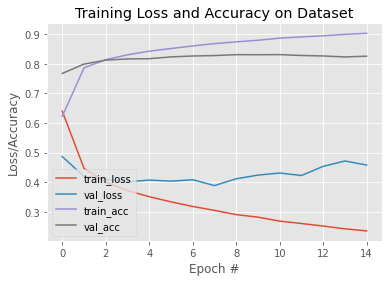

In [33]:
import matplotlib.pyplot as plt

N = min(NUM_EPOCHS, len(H.history["loss"]))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

---

## predict

In [ ]:
with open('bestmodel.txt', 'r') as file:
    best_model_path = file.read()

model = keras.models.load_model(best_model_path)

In [35]:
sent1_test, sent2_test, leaks_test, labels_test = load_preprocess(fn_cached_test)

In [ ]:
preds_test = model.predict(x=[sent1_test, sent2_test, leaks_test], verbose=1)

In [37]:
preds_test[preds_test <= 0.5] = 0.
preds_test[preds_test > 0.5] = 1.
preds_test = preds_test.astype("int32")

# preds_test = (preds_test > 0.5).astype("int32")

In [38]:
from sklearn.metrics import classification_report

print(classification_report(labels_test, preds_test))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     28609
           1       0.82      0.84      0.83     28396

    accuracy                           0.83     57005
   macro avg       0.83      0.83      0.83     57005
weighted avg       0.83      0.83      0.83     57005



In [39]:
np.unique(labels_test, return_counts=True)

(array([0, 1]), array([28609, 28396]))

In [40]:
np.unique(preds_test, return_counts=True)

(array([0, 1], dtype=int32), array([28009, 28996]))

In [ ]:
vocab_to_int, _, _ = load_preprocess(fn_cached_vocab)

In [ ]:
sent_pairs = [
    ['This is an example.', 'This is an example.'],
    ['This is an example.', 'This is not a good example.'],
    ['What can make Physics easy to learn?', 'How can you make physics easy to learn?'],
    ['How many times a day do a clocks hands overlap?', 'What does it mean that every time I look at the clock the numbers are the same?'],
    ['Fishes do not fly.', 'I like eating ice cream when the weather is really hot.'],
]
sent1, sent2 = zip(*sent_pairs)

test_data_x1, test_data_x2, leaks_test = create_test_data(sent1, sent2, vocab_to_int)

preds = model.predict([test_data_x1, test_data_x2, leaks_test], verbose=1)

print("\n")
for i in range(len(preds)):
    print("Sentance 1: " + sent1[i])
    print("Sentance 2: " + sent2[i])
    print("Similarity Score: " + str(calculate_total_score(preds[i])))
    print("\n")

In [ ]:
labels[20:30]